# Titanic Competition - Data Visualization & Machine Learning


## Introduction
**The most famous shipwreck in history**. Is there a pattern between the people who died and the people who survived?

![Titanic Infographic](https://images.squarespace-cdn.com/content/v1/5006453fe4b09ef2252ba068/1351660113175-514SN9PXFWB9N2MNB8DV/ke17ZwdGBToddI8pDm48kDJ9qXzk7iAyoryvGQVNA_F7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UcJGkCP2eEqMWqTLP4RLEZaxwnphfgit-_H6Nuosp50rm0sD-Bab7E9MY8W31A7zMQ/TItanic-Survival-Infographic.jpg?format=1000w)

### Imports

Import the **data science** and **machine learning** libraries.

In [1]:
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from datetime import datetime

#Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### From .csv to DataFrame
Read the data and import to a DataFrame.

In [2]:
df_gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

### Explore the DataFrames

Basic exploration of DataFrames: data, datatypes and data info.

In [3]:
## Print the 5 first rows of the DataFrame
#df_train.head()
#df_test.head()

## Print the shape
#df_train.shape
#df_test.shape

## Print the datatypes
#df_train.dtypes
#df_test.dtypes

## Info of DataFrame
#df_train.info()
#df_test.info()

## Describe the DataFrame. Basic descriptive stats
#df_train.describe()
#df_test.describe()

## Null data amout
#print(pd.isnull(df_train).sum())
#print(pd.isnull(df_test).sum())


## Data Wrangling

Adjust the data to be able to be processed.

### Parse sex to numbers

In [4]:
df_train['Sex'].replace(['female','male'],[0,1],inplace=True)
df_test['Sex'].replace(['female','male'],[0,1],inplace=True)

#### Print the death by sex

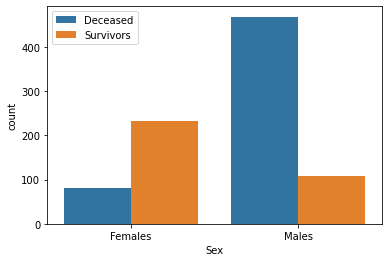

In [5]:
fig, ax = plt.subplots()
sns.countplot(x='Sex', hue ='Survived', data = df_train)
new_xtick = ['Females', 'Males']
ax.set_xticklabels(new_xtick)
new_legend = ['Deceased', 'Survivors']
plt.legend(new_legend)
plt.show()

### Parse shipping data to numbers

In [6]:
df_train['Embarked'].replace(['Q','S', 'C'],[0,1,2],inplace=True)
df_test['Embarked'].replace(['Q','S', 'C'],[0,1,2],inplace=True)

### Display death by embarked city

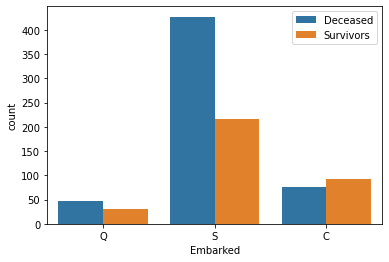

In [7]:
fig, ax = plt.subplots()
sns.countplot(x='Embarked',hue='Survived',data=df_train)
new_xtick = ['Q','S', 'C']
ax.set_xticklabels(new_xtick)
new_legend = ['Deceased', 'Survivors']
plt.legend(new_legend)
plt.show()

### Replace null age values for the average age

In [8]:
avg_age = ((df_train["Age"].mean() * df_train["Age"].shape[0]) + (df_test["Age"].mean() * df_test["Age"].shape[0]))/ (df_train["Age"].shape[0] + df_test["Age"].shape[0])
avg_age = np.round(avg_age)

df_train['Age'] = df_train['Age'].replace(np.nan, avg_age)
df_test['Age'] = df_test['Age'].replace(np.nan, avg_age)

### Segment the groups by age

In [9]:
#Bands: (1) 0-7, (2) 8-15, (3) 16-25, (4) 26-32, (5) 33-40, (6) 41-60, (7) 61-100
bins = [0, 7, 15, 25, 32, 40, 60, 100]
names = ['1', '2', '3', '4', '5', '6', '7']
df_train['Age'] = pd.cut(df_train['Age'], bins, labels = names)
df_test['Age'] = pd.cut(df_test['Age'], bins, labels = names)

df_train['Age'].groupby(df_train.Age).count()

Age
1     50
2     33
3    218
4    322
5    118
6    128
7     22
Name: Age, dtype: int64

### Display death by age group

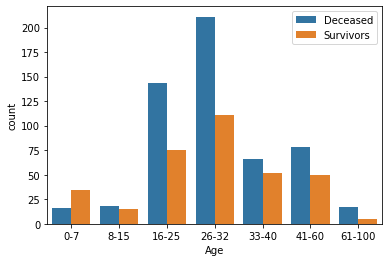

In [10]:
fig, ax = plt.subplots()
sns.countplot(x='Age',hue='Survived',data=df_train)
new_xtick = ['0-7', '8-15', '16-25','26-32','33-40','41-60','61-100']
ax.set_xticklabels(new_xtick)
new_legend = ['Deceased', 'Survivors']
plt.legend(new_legend)
plt.show()

### Drop no necessary columns for the data analysis

In [11]:
df_train.drop(['Cabin'], axis = 1, inplace=True)
df_test.drop(['Cabin'], axis = 1, inplace=True)
df_train = df_train.drop(['PassengerId','Name','Ticket'], axis=1)
df_test = df_test.drop(['Name','Ticket'], axis=1)

### Drop the rows with a null value

In [12]:
df_train.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)

### Columns dissociation
For improve the precission of the algorithm the best is dissasociate specific columns. Columns to dissociate:
- Age (Age Group)
- Embarked
- Pclass
- SibSp
- Parch

In [13]:
def column_dissociation(DataFrame, ColumnName):
    df = DataFrame
    uniques = df[ColumnName].drop_duplicates()#unique results of the column
    uniques = uniques.sort_values( ascending=True) #Sort the values
    new_column_name = ""
    for i, value in enumerate(uniques):
        new_column_name = ColumnName + '_' + str(value)
        df[new_column_name] = np.zeros(df.shape[0])
        df[new_column_name] = df[new_column_name].astype('int64')
        df.loc[df[ColumnName] == value, new_column_name] = 1
    df.drop([ColumnName], axis = 1, inplace=True)
    return df

In [14]:
def column_comparator(DataFrame1, DataFrame2):
    bool_test = False
    result = []
    for i, column1 in enumerate(DataFrame1):
        bool_test = False
        for j, column2 in enumerate(DataFrame2):
            if column1 == column2:
                bool_test = True 
                
        if not bool_test:
            result.append(column1)
    return result

In [15]:
def create_zeros_column(DataFrame, columns):
    df = DataFrame
    if len(columns) == 0:
        print('No columns added')
    elif isinstance(columns, str):
        df[columns] = np.zeros(df.shape[0])
        df[columns] = df[columns].astype('int64')
    else:
        for i, col in enumerate(columns):
            df[col] = np.zeros(df.shape[0])
            df[col] = df[col].astype('int64')
    return df

In [16]:
#- Age (Age Group)
df_train = column_dissociation(df_train, 'Age')
df_test = column_dissociation(df_test, 'Age')
#- Embarket
df_train = column_dissociation(df_train, 'Embarked')
df_test = column_dissociation(df_test, 'Embarked')
#- Pclass
df_train = column_dissociation(df_train, 'Pclass')
df_test = column_dissociation(df_test, 'Pclass')
#- SibSp
df_train = column_dissociation(df_train, 'SibSp')
df_test = column_dissociation(df_test, 'SibSp')
#- Parch
df_train = column_dissociation(df_train, 'Parch')
df_test = column_dissociation(df_test, 'Parch')

#Are there any column in a dataFrame that are not in the other
cc1 = column_comparator(df_test,df_train)
print(cc1)
cc2 = column_comparator(df_train, df_test)
print(cc2)
df_train = create_zeros_column(df_train, 'Parch_9')

['PassengerId', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Parch_9']
['Survived', 'Embarked_0.0', 'Embarked_1.0', 'Embarked_2.0']


### Correlation Heatmap

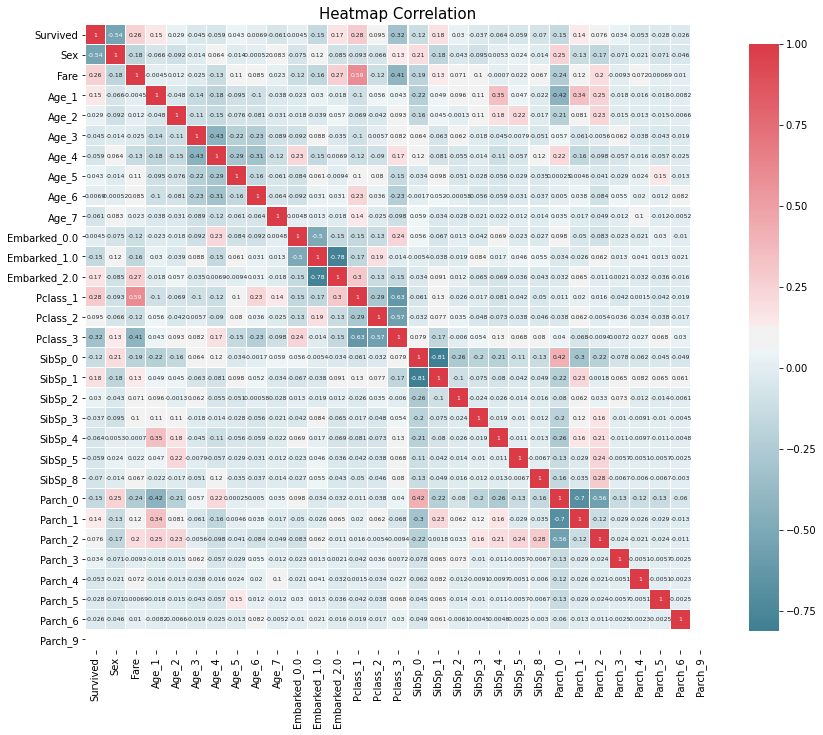

In [17]:
# Correlation Heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':6 }
    )
    
    plt.title('Heatmap Correlation', y=1.05, size=15)

correlation_heatmap(df_train)

## Machine Learning Data Analysis

For this problem we have to select the classification algorithms. The algorithms I have to compare will be:
1. [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
2. [K-nearest neighbors classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) 
3. [Support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine)
4. [Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)
5. [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
6. [XGBoost Classifier](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)
7. [Multi-Layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)

### Split the column of surveillance of the rest of DataFrame

In [18]:
X = np.array(df_train.drop(['Survived'], 1))
y = np.array(df_train['Survived'])

### Split a part of the train dataset for test the algorithms
Adjust the test size to a 20%.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Test the algoritms

In [20]:
##Logistic Regression
logreg = LogisticRegression(max_iter = 100000)
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)

print('Logistic Regression')
print('Score: ' + str(logreg.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##K neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)

print('K-Nearest Neighbors Classifier')
print('Score: ' + str(knn.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Support Vector Machines
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)

print('Support Vector Machine Classifier')
print('Score: ' + str(svc.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)

print('Perceptron Classifier')
print('Score: ' + str(perceptron.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##XGBoost Classifier
xgboost = XGBClassifier(learning_rate=1.3, n_estimators=2000, max_depth=40, min_child_weight=40, 
                      gamma=0.4,nthread=10, subsample=0.8, colsample_bytree=.8, 
                      objective= 'binary:logistic',scale_pos_weight=10,seed=29)
xgboost.fit(X_train, y_train)
Y_pred = xgboost.predict(X_test)

print('XGBoost Classifier')
print('Score: ' + str(xgboost.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Random Forest
random_forest = RandomForestClassifier(n_estimators=1000, random_state = 0)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

print('Random Forest Classifier')
print('Score: ' + str(random_forest.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Multi-Layer Perceptron Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes = 1000, alpha = 0.00001, learning_rate = 'adaptive', learning_rate_init = 0.001, random_state = 0, max_iter = 100000 )
mlp_classifier.fit(X_train, y_train)
Y_pred = mlp_classifier.predict(X_test)
mlp_classifier.score(X_train, y_train)

print('Multi-Layer Perceptron Classifier')
print('Score: ' + str(mlp_classifier.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')


##AdaBoostClassifier
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
Y_pred = adaboost.predict(X_test)
adaboost.score(X_train, y_train)

print('AdaBoost Classifier')
print('Score: ' + str(adaboost.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Linear Discriminant Analysis
lineardiscriminant = LinearDiscriminantAnalysis()
lineardiscriminant.fit(X_train, y_train)
Y_pred = lineardiscriminant.predict(X_test)
lineardiscriminant.score(X_train, y_train)

print('Linear Discriminant Analysis')
print('Score: ' + str(lineardiscriminant.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')

##Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)
Y_pred = gradient_boosting.predict(X_test)
gradient_boosting.score(X_train, y_train)

print('Gradient Boosting Classifier')
print('Score: ' + str(gradient_boosting.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')


##Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
decision_tree.score(X_train, y_train)

print('Decision Tree Classifier')
print('Score: ' + str(decision_tree.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')


##Decision Tree Classifier
extra_tree = DecisionTreeClassifier()
extra_tree.fit(X_train, y_train)
Y_pred = extra_tree.predict(X_test)
extra_tree.score(X_train, y_train)

print('Decision Tree Classifier')
print('Score: ' + str(extra_tree.score(X_train, y_train)))
print('Accuracy: '+ str(accuracy_score(y_test, Y_pred)))
print('Confusion Matrix:')
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print('------------------------------------')



Logistic Regression
Score: 0.8284106891701828
Accuracy: 0.7640449438202247
Confusion Matrix:
[[86 23]
 [19 50]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       109
           1       0.68      0.72      0.70        69

    accuracy                           0.76       178
   macro avg       0.75      0.76      0.75       178
weighted avg       0.77      0.76      0.77       178

------------------------------------
K-Nearest Neighbors Classifier
Score: 0.8523206751054853
Accuracy: 0.6853932584269663
Confusion Matrix:
[[76 33]
 [23 46]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       109
           1       0.58      0.67      0.62        69

    accuracy                           0.69       178
   macro avg       0.67      0.68      0.68       178
weighted avg       0.70      0.69      0.69       178

------------------------------------
Support Vector Machine Classifier
Sco

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Classifier
Score: 0.7805907172995781
Accuracy: 0.6629213483146067
Confusion Matrix:
[[58 51]
 [ 9 60]]
              precision    recall  f1-score   support

           0       0.87      0.53      0.66       109
           1       0.54      0.87      0.67        69

    accuracy                           0.66       178
   macro avg       0.70      0.70      0.66       178
weighted avg       0.74      0.66      0.66       178

------------------------------------
Random Forest Classifier
Score: 0.9535864978902954
Accuracy: 0.7247191011235955
Confusion Matrix:
[[77 32]
 [17 52]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       109
           1       0.62      0.75      0.68        69

    accuracy                           0.72       178
   macro avg       0.72      0.73      0.72       178
weighted avg       0.74      0.72      0.73       178

------------------------------------
Multi-Layer Perceptron Classifier
Score: 0.8

In this case, the most accurate algorithm is the [random forest](https://en.wikipedia.org/wiki/Random_forest) and the multi-layer preceptron ([neural network](https://en.wikipedia.org/wiki/Artificial_neural_network)).

### Cross Validation
Select the best model using [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).
From this point on, notebook code is reused [Titanic Top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling). 
I highly recommend to view this notebook.

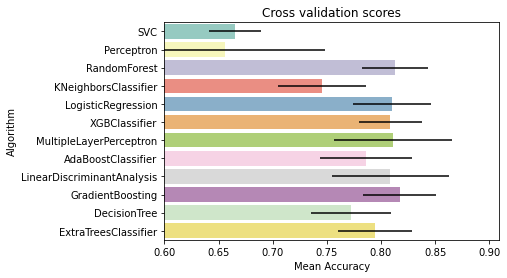

In [21]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)


# Modeling step Test differents algorithms 
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(Perceptron(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(XGBClassifier())
classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","Perceptron",
"RandomForest","KNeighborsClassifier","LogisticRegression","XGBClassifier","MultipleLayerPerceptron", "AdaBoostClassifier", "LinearDiscriminantAnalysis", "GradientBoosting", "DecisionTree", "ExtraTreesClassifier"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g.set_xlim(xmin=0.6)
g = g.set_title("Cross validation scores")


### Tunning the hyperparameters
I choose the most responsive algorithm which is the **Gradient Descent** and we tune the hyperparameters.

In [22]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300, 400, 500, 750, 1000],
              'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
              'max_depth': [4, 8, 16, 32, 64, 128],
              'min_samples_leaf': [100,150, 200, 250],
              'max_features': [0.3, 0.1, 0.05, 0.01] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)


In [23]:
gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 3360 candidates, totalling 33600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done 462 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 812 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1262 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1812 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 2462 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 3212 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 4062 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 5012 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done 6062 tasks      | elapsed: 19.6min
[Parallel(n_jobs=4)]: Done 7212 tasks      | elapsed: 23.3min
[Parallel(n_jobs=4)]: Done 8462 tasks      | elapsed: 27.2min
[Parallel(n_jobs=4)]: Done 9812 tasks      | elapsed: 31.4min
[Parallel(n_jobs=4)]: Done 11262 tasks      | elapsed: 36.0mi

0.8255672926447574

### Learning curves

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

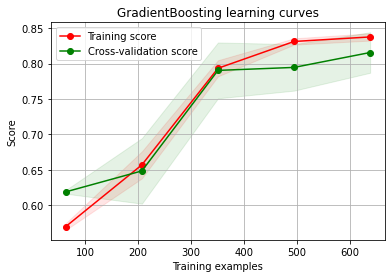

In [25]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

### Prediction

In [26]:
## Choose the best algorithms (ensembled mode)
model = gsGBC

ids = df_test['PassengerId']

##Result
prediction = model.predict(df_test.drop('PassengerId', axis=1))
out_pred = pd.DataFrame({ 'PassengerId' : ids, 'Survived': prediction })


### Choose the best algorithm (the most accurate)

Export the result to `.csv`. The result of these notebook is `0.77033`.

In [27]:
df_sup = pd.DataFrame({"PassengerId":[1044], "Survived":[0]}) 
out_pred = out_pred.append(df_sup)
out_pred = out_pred.sort_values(by='PassengerId', ascending=True)

out_pred.to_csv('Submission.csv', index = False)